# Fetching crypto and tweets data.

In [226]:
from sklearn.preprocessing import OrdinalEncoder
from TweetScraper import TweetScraper
from CryptoApi import CryptoApi
import pandas as pd
import numpy as np
import re


# scrp = TweetScraper(start='2023-05-04', end='2023-05-14', maxEmptyPages=2, max_workers=8)
# new_tweets = scrp.parallel_download_tweets()
# new_twt = pd.DataFrame(new_tweets)


# with open('crypto_token.txt','r') as f:
#     token = f.readline()
    
# crypto = CryptoApi(token)
# crypto.get_data('btc','usd','day',period_count=90)

# Analysis of tweets

In [227]:
tweets_df = pd.read_csv(r'Data/elon_tweets.csv', index_col=0)

## Dealing with sparse columns

In [228]:
sparse_cols = tweets_df.columns[tweets_df.notnull().mean() < 1.0].values.copy()

mod_tweets_df = tweets_df.copy()
mod_tweets_df = (mod_tweets_df[mod_tweets_df['lang']=='en']
                 .drop(['id','url','source','sourceUrl'], axis=1)                 
                 .reset_index(drop=True)
                 .copy())

mod_tweets_df = mod_tweets_df.drop(['lang'], axis=1)

## Data cleaning and preprocessing

In [229]:
encoder = OrdinalEncoder()
mod_tweets_df['sourceLabel_encoded'] = encoder.fit_transform(mod_tweets_df['sourceLabel'].values.reshape(-1, 1))
mod_tweets_df['isReplied']   = [0 if type(tweet)==float else 1 for tweet in mod_tweets_df['inReplyToUser']]
mod_tweets_df['isMentioned'] = [0 if type(tweet)==float else 1 for tweet in mod_tweets_df['mentionedUsers']]
#mod_tweets_df = mod_tweets_df.drop(['sourceLabel','inReplyToUser','mentionedUsers'], axis=1)


def extract_dict(line: str, prepare_to_df: False):
    """Extracts data from a dict represented as string and makes it a dict.

    ## Parameters:
        line (str): row of a Series/DataFrame to be preprocessed.
        prepare_to_df (bool): prepares extracted dict to be wrapped into DataFrame.

    ## Returns:
        dict: extracted dict from string.
    """    

    extracted_content = dict(re.findall(r"'(\w+)': '?({.*}|datetime.datetime\(.*\)|[\w\d/:\. ]*)'?", line))
    
    # Wraps dict values into lists to be easily represented as a DataFrame row.
    if prepare_to_df:
        for key,value in extracted_content.items():
            if value == '':
                extracted_content[key] = [None]
            else:
                extracted_content[key] = value
        
    return extracted_content


extracted_df = (pd.DataFrame([*mod_tweets_df['user']
                              .apply(lambda x: extract_dict(x, True))])
                )

mod_tweets_df = (pd.concat([mod_tweets_df, extracted_df], axis=1)
                 .drop(['user','username','id','displayname','verified','created',
                        'location','protected','profileImageUrl','profileBannerUrl',
                        'rawDescription','renderedDescription','favouritesCount',
                        'friendsCount','mediaCount','statusesCount','inReplyToTweetId'], axis=1))

In [230]:
# Converting columns containing numbers to int after extraction.
for column in mod_tweets_df:
    if 'Count' in column:
        mod_tweets_df[column] = mod_tweets_df[column].astype('Int64').copy()

In [231]:
# mod_tweets_df[['rawContent','isReplied','isMentioned']].query("rawContent.str.contains('@')")

mod_tweets_df['mentionsCount'] = mod_tweets_df['rawContent'].str.count(r'@[\w\d]+')
mod_tweets_df['mentions'] = mod_tweets_df['rawContent'].apply(lambda x : re.findall(r'(@[^\s]+)', x))

count = 0
for a,b in mod_tweets_df[['mentionsCount','mentions']].values:
    if a==len(b):
        count +=1 
print(count==len(mod_tweets_df))

mod_tweets_df['charCount'] = mod_tweets_df['rawContent'].apply(lambda x: len(x))
mod_tweets_df = mod_tweets_df.drop('descriptionLinks', axis=1)

True


In [232]:
#links = tweets_df[tweets_df.columns[tweets_df.columns.isin(mod_tweets_df.columns)==False]]['links'].value_counts().copy()

tweets_df[tweets_df['rawContent']=='True']['quotedTweet'].iloc[0]

'{\'url\': \'https://twitter.com/ggreenwald/status/1625871270737809408\', \'date\': datetime.datetime(2023, 2, 15, 14, 54, 52, tzinfo=datetime.timezone.utc), \'rawContent\': "The corporate media\'s ability to -- overnight -- turn anyone who dissents in anyway into some sort of fascist or even Hitler-like figure, and then have millions of their followers go around mindlessly repeating it, is both impressive and chilling:", \'renderedContent\': "The corporate media\'s ability to -- overnight -- turn anyone who dissents in anyway into some sort of fascist or even Hitler-like figure, and then have millions of their followers go around mindlessly repeating it, is both impressive and chilling:", \'id\': 1625871270737809408, \'user\': {\'username\': \'ggreenwald\', \'id\': 16076032, \'displayname\': \'Glenn Greenwald\', \'rawDescription\': \'Journalist; Author; Host, @SystemUpdate_; Columnist, @Folha; Co-Founder: The Intercept, @TheInterceptBr; @abrigo_hope, @FreedomofPress, @ongcriadefavela.

In [233]:
import re
import json
import datetime


def clean_text(raw_text):    
    cleaned_text = re.sub(r' \'?(displayname|renderedDescription)\'?: (.*?)(\'|None),', '', raw_text)
    cleaned_text = (cleaned_text
                    .replace("'",'"')
                    .replace('None','null')
                    .replace('True','true')
                    .replace('False','false'))
    # cleaned_text = re.sub(r'(\w+)"(\w+)', r"\1'\2", cleaned_text)
    
    return cleaned_text


def deserialize(text):    
    deserialized_texts = []
    extract_dicts = re.findall(r'{.*?}',text)
    
    for str_dict in extract_dicts:
        cleaned_text = clean_text(str_dict)

        pattern = r'datetime.datetime\(.*\)'
        cleaned_text = re.sub(f'({pattern})',r'"\1"',cleaned_text)
        
        deserialized_text = json.loads(cleaned_text)
        
        if deserialized_text['created']!=None:
            deserialized_text['created'] = eval(deserialized_text['created'])
        
        deserialized_texts.append(deserialized_text)

    return deserialized_texts
    
    
mod_tweets_df = mod_tweets_df.drop(['links','media','link','inReplyToUser'], axis=1)
mod_tweets_df['mentionedUsers'] = mod_tweets_df['mentionedUsers'].apply(lambda x: deserialize(x) if type(x)==str else None)

In [234]:
from sklearn.preprocessing import OneHotEncoder


encoder = OneHotEncoder()
mod_tweets_df[encoder.categories_[0]] =  encoder.fit_transform(mod_tweets_df[['sourceLabel']]).toarray()
mod_tweets_df = mod_tweets_df.drop(['renderedContent','conversationId',
                                    'sourceLabel','mentions', 
                                    'cashtags','vibe'], axis=1)

object_features = mod_tweets_df[mod_tweets_df.dtypes[mod_tweets_df.dtypes==object].index].copy()
object_features['mentionsCount'] = object_features['mentionedUsers'].apply(lambda x: len(x) if x!=None else 0)
object_features = object_features.drop(['mentionedUsers','label'], axis=1)

def extract_quoted_tweet(tweet):
    if type(tweet)!=float:
        text = re.findall(r"'rawContent': '?(.*?)'?, 'renderedContent'",tweet)[0]
        name = re.findall(r"'user': {'username': '?(.*?)'?,",tweet)[0]
        result = pd.Series({'quoted_text':text, 'quoted_username':name})
    else:
        result = pd.Series({'quoted_text':None, 'quoted_username':None})
        
    return result


extracted_quoted_tweets = object_features['quotedTweet'].apply(lambda x: extract_quoted_tweet(x))
object_features = pd.concat([object_features, extracted_quoted_tweets], axis=1)

# mergins cleaned object cols
mod_tweets_df[object_features.columns] = object_features.copy()
mod_tweets_df = mod_tweets_df.drop(['mentionedUsers','label','quotedTweet'], axis=1)

In [235]:
# mod_tweets_df['rawContent'] = mod_tweets_df['rawContent'].str.replace('@','')

# NLP Model Bulding

## Preprocessing and vectorizing

In [237]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
import TextPreprocess.TextPreprocessor as tp 
from gensim import corpora, matutils, utils, models
from sklearn.pipeline import Pipeline
import spacy


preprocessing_pipeline = tp.make_pipeline()
id2word, corpus = preprocessing_pipeline.transform(mod_tweets_df['rawContent'].values.tolist())


def prepare_tfidf():
    with open('lemmatized_texts.txt', 'r', encoding="utf-8") as f:
        lemmatized_texts = f.readlines()
    
    lemmatized_texts = [line.replace('\n','') for line in lemmatized_texts]

    lemmatized_texts = lemmatization(mod_tweets_df['rawContent'])

    data_bigrams_trigrams = create_ngrams(lemmatized_texts)
    id2word, corpus = vectorize_texts(data_bigrams_trigrams)

    tfidf = models.TfidfModel(corpus, id2word=id2word)
    tfidf_vectorizer = TfidfVectorizer(max_df=0.6,
                                       min_df=5,
                                       ngram_range=(1,3))
    tfidf_matrix = tfidf_vectorizer.fit_transform(lemmatized_texts)

    id2word = dict((v, k) for k, v in tfidf_vectorizer.vocabulary_.items())
    corpus = matutils.Sparse2Corpus(tfidf_matrix.T)

    low_value = 0.03
    words = []
    words_missing_in_tfidf = []

    for i in range(0, len(corpus)):
        bow = corpus[i]
        low_value_words = []
        tfidf_ids = [id for id,_ in tfidf[bow]]
        bow_idf = [id for id,_ in bow]
        low_value_words = [id for id, value in tfidf[bow] if value < low_value]
        drops = low_value_words+words_missing_in_tfidf
        
        for item in drops:
            words.append(id2word[item])
        
        # words with tfidf score of 0 will be missing
        words_missing_in_tfidf = [id for id in bow_idf if id not in tfidf_ids]
        new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
        corpus[i] = new_bow

In [238]:
from gensim.models import CoherenceModel


def bayesian_tuning(model, params_grid: dict, texts, verbose=False):
    # TODO: implement bayesian tuning
    models_scores = {}
    for i in range(95,170,5):
        lda_model = model(corpus=params_grid['corpus'],
                          num_topics=i,
                          id2word=params_grid['id2word'],
                          random_state=1,
                          passes=10,
                          per_word_topics=True)
        
        coherence_model_lda = CoherenceModel(model=lda_model, 
                                             texts=texts, 
                                             corpus=params_grid['corpus'], 
                                             dictionary=params_grid['id2word']
                                             )
        coherence_score = coherence_model_lda.get_coherence()
        
        models_scores.update({lda_model: coherence_score})
        
        if verbose:
            print(f'Topics {i:<3}: {coherence_score}')
    
    return models_scores


params_grid = {'corpus':corpus,  
               'num_topics':10, 
               'id2word':id2word, 
               'random_state':1, 
               'update_every':1, 
               'chunksize':3000, 
               'passes':2}

# lda_models_scores = bayesian_tuning(LdaMulticore, params_grid, texts, verbose=True)

In [239]:
import pyLDAvis.gensim_models as gensimvis
from gensim.models import LdaMulticore
import pyLDAvis


pyLDAvis.enable_notebook()

lda_model = LdaMulticore(corpus=corpus,
                         num_topics=25,
                         id2word=id2word,
                         random_state=1,
                         passes=10,
                         per_word_topics=True)

vis = gensimvis.prepare(lda_model, corpus, id2word)

# for prediction


vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
20     0.057361  0.097947       1        1  5.888042
24     0.080253  0.090825       2        1  5.341536
7      0.125564  0.051829       3        1  5.091131
14     0.071128 -0.020249       4        1  4.484301
19    -0.056030  0.081422       5        1  4.406100
8      0.015738 -0.016927       6        1  4.396782
0      0.027202  0.050190       7        1  4.340409
17    -0.145632 -0.048109       8        1  4.321307
4      0.080281 -0.087651       9        1  4.243645
9      0.043561  0.102004      10        1  4.112881
23    -0.009768 -0.002570      11        1  4.096521
21     0.100625 -0.010319      12        1  4.087566
1      0.015365  0.038145      13        1  4.029531
15     0.091992 -0.163344      14        1  3.863509
22    -0.020777 -0.050952      15        1  3.738387
11    -0.048066 -0.002528      16        1  3.588214
18     0.029690 -0.012682      17        1  3.579582
5     -0.115847 -0.039561      18        1  3.494610
10    -0.028941  0.028562      19        1  3.478192
3     -0.004601  0.032081      20        1  3.351920
16    -0.118967  0.066554      21        1  3.325579
2     -0.063831 -0.010654      22        1  3.298289
13     0.002040 -0.160844      23        1  3.233951
12    -0.053008 -0.058685      24        1  3.120824
6     -0.075330  0.045514      25        1  3.087192, topic_info=         Term        Freq       Total Category  logprob  loglift
29       true  336.000000  336.000000  Default  30.0000  30.0000
999   exactly  343.000000  343.000000  Default  29.0000  29.0000
9232   billym  443.000000  443.000000  Default  28.0000  28.0000
70       good  787.000000  787.000000  Default  27.0000  27.0000
32      great  554.000000  554.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
1672   result   10.489303   64.133120  Topic25  -5.7268   1.6673
6        need   14.599306  564.153270  Topic25  -5.3962  -0.1764
217     think   11.887942  311.043396  Topic25  -5.6017   0.2135
1265  company   11.036812  205.424355  Topic25  -5.6759   0.5541
207     thing   10.158113  281.286342  Topic25  -5.7589   0.1568

[1839 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
9639      22  0.842011        abide
186        5  0.835633   absolutely
186        7  0.075967   absolutely
186       10  0.013812   absolutely
186       19  0.034530   absolutely
...      ...       ...          ...
11355     22  0.923632  zaleskiluke
11725     14  0.912671   zattestore
2589       2  0.178402         zone
2589       4  0.802809         zone
10885     16  0.777718    zubymusic

[6896 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[21, 25, 8, 15, 20, 9, 1, 18, 5, 10, 24, 22, 2, 16, 23, 12, 19, 6, 11, 4, 17, 3, 14, 13, 7])

## Merging NLP results into crypto data.

In [241]:
mod_tweets_df['vectorized']  = preprocessing_pipeline.transform(mod_tweets_df['rawContent'].values.tolist())[1]
mod_tweets_df['TopicsProbs'] = mod_tweets_df['vectorized'].apply(lambda x: dict(lda_model.get_document_topics(x, minimum_probability=0)))

In [244]:
btc_df = pd.read_csv('Data/btc_data.csv', index_col=0)
btc_df = btc_df.rename(columns={'time':'date'})
btc_df['date'] = pd.to_datetime(btc_df['date']).dt.date

topics_df = pd.DataFrame(mod_tweets_df['TopicsProbs'].tolist())
for col in topics_df.columns:
    topics_df = topics_df.rename({col:f'T-{col}'}, axis=1)

topics_tweets_df = pd.concat([mod_tweets_df, topics_df], axis=1).copy()
topics_tweets_df = topics_tweets_df.drop(['vectorized', 'TopicsProbs'], axis=1)
topics_tweets_df['date'] = pd.to_datetime(topics_tweets_df['date']).dt.date

In [245]:
import utils


sparse_cols = utils.find_sparse_cols(topics_tweets_df)
topics_tweets_df = topics_tweets_df[sparse_cols]

aggs = utils.make_aggregator(topics_tweets_df)

grouped_df = (topics_tweets_df
              .groupby('date')
              .agg(aggs).reset_index())

To drop:
retweetedTweet     0.000000
coordinates        0.000000
place              0.000000
hashtags           0.002238
card               0.041658
viewCount          0.119786
quoted_text        0.030138
quoted_username    0.030138
dtype: float64


In [246]:
topics_btc = pd.merge(btc_df, grouped_df, on='date', how='inner')
sparse_cols = utils.find_sparse_cols(topics_btc)
topics_btc = topics_btc[sparse_cols].drop(['date', 'rawContent','conversionType'], axis=1) 

To drop:
conversionSymbol    0.0
dtype: float64


# Time-series model bulding

In [247]:
import xgboost as xgb
from sklearn.model_selection import train_test_split


X = topics_btc.drop('close', axis=1)
y = topics_btc['close']

train, test, labels_train,labels_test = train_test_split(X, y, train_size=0.8)

dtrain = xgb.DMatrix(train, label=labels_train)
dtest  = xgb.DMatrix(test, label=labels_test)

param = {'max_depth': 12, 'objective': 'reg:squarederror'}
param['nthread'] = 8
param['eval_metric'] = 'mape'
#param['eval_metric'] = 'auc'
evallist = [(dtrain, 'train'), (dtest, 'test')]

num_round = 30
bst = xgb.train(param, dtrain, num_round, evals=evallist)

[0]	train-mape:0.70112	test-mape:0.70334
[1]	train-mape:0.49147	test-mape:0.49505
[2]	train-mape:0.34485	test-mape:0.34893
[3]	train-mape:0.24187	test-mape:0.24666
[4]	train-mape:0.16983	test-mape:0.17403
[5]	train-mape:0.11916	test-mape:0.12312
[6]	train-mape:0.08362	test-mape:0.08748
[7]	train-mape:0.05895	test-mape:0.06325
[8]	train-mape:0.04180	test-mape:0.04682
[9]	train-mape:0.02992	test-mape:0.03655
[10]	train-mape:0.02164	test-mape:0.03023
[11]	train-mape:0.01575	test-mape:0.02629
[12]	train-mape:0.01151	test-mape:0.02414
[13]	train-mape:0.00849	test-mape:0.02273
[14]	train-mape:0.00633	test-mape:0.02182
[15]	train-mape:0.00475	test-mape:0.02145
[16]	train-mape:0.00359	test-mape:0.02117
[17]	train-mape:0.00275	test-mape:0.02099
[18]	train-mape:0.00214	test-mape:0.02081
[19]	train-mape:0.00173	test-mape:0.02072
[20]	train-mape:0.00144	test-mape:0.02065
[21]	train-mape:0.00124	test-mape:0.02062
[22]	train-mape:0.00107	test-mape:0.02059
[23]	train-mape:0.00092	test-mape:0.02059
[2

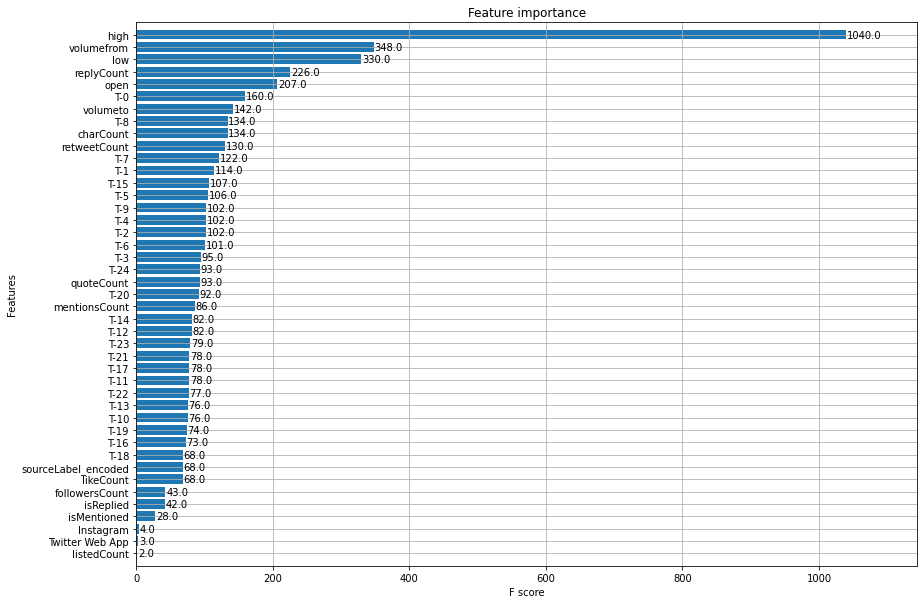

In [248]:
ax = xgb.plot_importance(bst, height=0.8)
fig = ax.figure
fig.set_size_inches(14, 10)